# CNN training and testing for MitoSplit-Net

### Import required Python libraries



In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)
import napari
from skimage import morphology, segmentation
from skimage.util import compare_images
from skimage.io import imread, imsave

import h5py   # HDF5 data file management library
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from tensorflow.python.keras.layers import concatenate, UpSampling2D, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

from glob import glob
from tqdm.notebook import tqdm

### Import and reshape data 

In [3]:
data_path = 'Y:/Model/'  # nb: begin with /

#Inputs
#Mito
input_data_filename = data_path + 'Mito.h5' 
input_data = np.array(h5py.File(input_data_filename, 'r').get('Mito'))
print('Inputs'+':', input_data.shape)

#Outputs
output_data_filename = data_path + 'Proc.h5'
output_data = np.array(h5py.File(output_data_filename, 'r').get('Proc'))
print('Outputs:', output_data.shape)

Inputs: (37000, 128, 128)
Outputs: (37000, 128, 128)


In [137]:
def plot_comparison(input_data, output_data, frame, cmap = ['gray', 'inferno'],
                    labels=['input_data', 'output_data', 'merge']):
  vmax= 255
  title_size = 20
  fig, axes = plt.subplots(1, 3, figsize=(5*3, 5))
  for ax, data, c, title in zip(axes[:2], [input_data, output_data], cmap, labels[:2]):
    ax.set_title(title+'[%i]'%frame, size=title_size)
    ax.imshow(data[frame], cmap=c, vmax=vmax)
    ax.axis('off')


  axes[2].set_title('Merge', size=title_size)
  #axes[2].imshow(merge)
  axes[2].imshow(input_data[frame], cmap=cmap[0], vmax=vmax)
  axes[2].imshow(output_data[frame], cmap=cmap[1], alpha=0.7, vmax=vmax)

  axes[2].set(xticks=[], yticks=[])
  axes[2].axis('off')
  
  plt.subplots_adjust(wspace=0.05)
  return axes

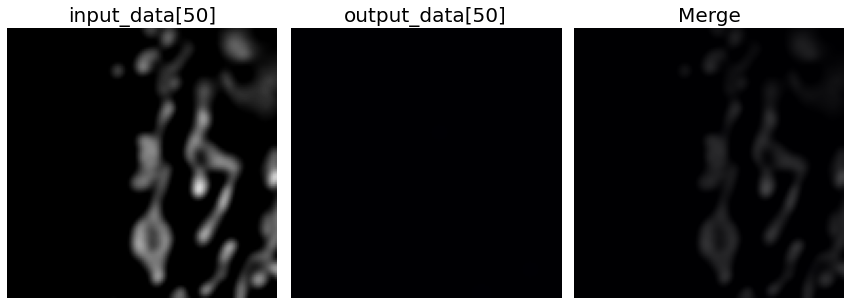

In [138]:
frame = 50

plot_comparison(input_data, output_data, frame)
plt.show()

In [131]:
blending = 'additive'
opacity = 0.7

cmap_mito = 'gray'
cmap_drp1 = 'green'

cmap_output = 'red'
gamma_output = 0.2

viewer = napari.Viewer()
viewer.add_image(input_data, colormap=cmap_mito, 
                 blending=blending, opacity=opacity, name='Mito')
viewer.add_image(output_data, colormap=cmap_output, 
                 blending=blending, gamma=gamma_output, name='Output')

<Image layer 'Output' at 0x25e07aaa4f0>

## Split train and test

In [ ]:
# Split data set into [test] and [train+valid] subsets using sklearn train_test_split function

data_set_test_trainvalid_ratio = 0.2
data_split_state = None   # integer (usually 42) or None for random split on each call
input_train, input_test, output_train, output_test =  train_test_split(input_data, 
                                                                       output_data, 
                                                                       test_size=data_set_test_trainvalid_ratio, 
                                                                       random_state=data_split_state)

print('test:[train+valid] split ratio : ', data_set_test_trainvalid_ratio)
print('data_split_state : ', data_split_state)
print()

print('input_data : ', input_data.shape, input_data.dtype)
print('input_train : ', input_train.shape, input_train.dtype)
print('input_test : ', input_test.shape, input_test.dtype)
print()
print('output_data : ', output_data.shape, output_data.dtype)
print('output_train : ', output_train.shape, output_train.dtype)
print('output_test : ', output_test.shape, output_test.dtype)

### Hyperparameters

In [ ]:
optimizer_type = Adam(learning_rate=0.5e-3)  # optimisation algorithm: Adam 
loss = 'mean_squared_error'  # loss (cost) function to be minimised by the optimiser
metrics = ['mean_absolute_error']  # network accuracy metric to be determined after each epoch
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 20  # maxmimum number of epochs to be iterated
batch_size = 256   # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch

nb_filters = 8
firstConvSize = 9

### Network architecture

In [ ]:
input_shape = (128, 128, 2,1)
inputs = Input(shape=input_shape)

# encoder section

down0 = Conv3D(nb_filters, (firstConvSize, firstConvSize, 2), padding='same')(inputs)
down0 = BatchNormalization()(down0)
down0 = Activation('relu')(down0)
down0 = Conv3D(nb_filters, (firstConvSize, firstConvSize, 2), padding='same')(down0)
down0 = BatchNormalization()(down0)
down0 = Activation('relu')(down0)
down0_pool = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(down0)
down0_pool = Reshape((64, 64, nb_filters))(down0_pool)
down0 = Reshape((128,128,nb_filters*2))(down0)
    
down1 = Conv2D(nb_filters*2, (3, 3), padding='same')(down0_pool)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1 = Conv2D(nb_filters*2, (3, 3), padding='same')(down1)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    
# center section
    
center = Conv2D(nb_filters*4, (3, 3), padding='same')(down1_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center)
center = Conv2D(nb_filters*4, (3, 3), padding='same')(center)
center = BatchNormalization()(center)
center = Activation('relu')(center)
    
# decoder section with skip connections to the encoder section

up1 = UpSampling2D((2, 2))(center)
up1 = concatenate([down1, up1], axis=3)
up1 = Conv2D(nb_filters*2, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(nb_filters*2, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)

up0 = UpSampling2D((2, 2))(up1)
up0 = concatenate([down0, up0], axis=3)
up0 = Conv2D(nb_filters, (3, 3), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)
up0 = Conv2D(nb_filters, (3, 3), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)

outputs = Conv2D(1, (1, 1), activation='relu')(up0)

### Compile the network

In [ ]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)
print(model.summary())  
print()

### Training

In [ ]:
print('Training initiated')
print()

history = model.fit(input_train, output_train,
                    batch_size=batch_size,
                    epochs=max_epochs,
                    validation_split=validtrain_split_ratio,
                    shuffle=batch_shuffle)

print()
print('Training completed')
print()